# Planetary Motion in 2D


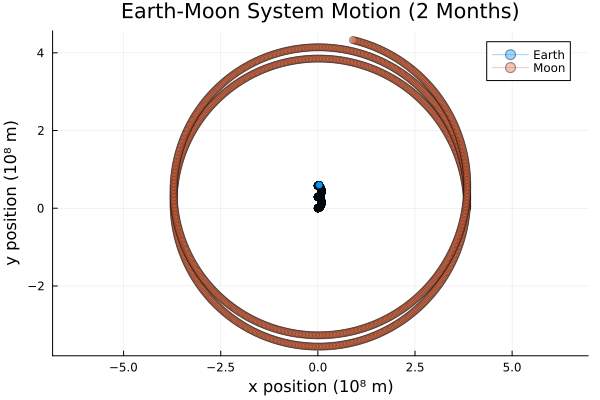

In [3]:
using LinearAlgebra
using Plots

# Define a structure to hold the state of a body
struct Body
    mass::Float64
    position::Vector{Float64}
    velocity::Vector{Float64}
end

# Define the system state
mutable struct TwoBodySystem
    body1::Body
    body2::Body
    time::Float64
end

# Gravitational constant (in SI units: m^3 kg^-1 s^-2)
const G = 6.67430e-11

# Calculate acceleration on body1 due to body2
function gravitational_acceleration(b1::Body, b2::Body)
    r = b2.position - b1.position
    distance = norm(r)
    force_magnitude = G * b1.mass * b2.mass / distance^2
    force_direction = r / distance
    # Return acceleration (F/m)
    return (force_magnitude / b1.mass) * force_direction
end

# Calculate accelerations for both bodies
function calculate_accelerations(system::TwoBodySystem)
    a1 = gravitational_acceleration(system.body1, system.body2)
    a2 = gravitational_acceleration(system.body2, system.body1)
    return a1, a2
end

# Update the system using Velocity Verlet method
function step!(system::TwoBodySystem, dt::Float64)
    # Step 1: Calculate current accelerations
    a1_current, a2_current = calculate_accelerations(system)
    
    # Step 2: Update positions using current velocities and accelerations
    new_p1 = system.body1.position + system.body1.velocity * dt + 0.5 * a1_current * dt^2
    new_p2 = system.body2.position + system.body2.velocity * dt + 0.5 * a2_current * dt^2
    
    # Step 3: Create temporary bodies with new positions (but old velocities)
    temp_body1 = Body(system.body1.mass, new_p1, system.body1.velocity)
    temp_body2 = Body(system.body2.mass, new_p2, system.body2.velocity)
    temp_system = TwoBodySystem(temp_body1, temp_body2, system.time)
    
    # Step 4: Calculate new accelerations at new positions
    a1_new, a2_new = calculate_accelerations(temp_system)
    
    # Step 5: Update velocities using average of old and new accelerations
    new_v1 = system.body1.velocity + 0.5 * (a1_current + a1_new) * dt
    new_v2 = system.body2.velocity + 0.5 * (a2_current + a2_new) * dt
    
    # Step 6: Update the system with new positions and velocities
    system.body1 = Body(system.body1.mass, new_p1, new_v1)
    system.body2 = Body(system.body2.mass, new_p2, new_v2)
    system.time += dt
end

# Calculate total energy of the system (for verification)
function total_energy(system::TwoBodySystem)
    # Kinetic energy
    ke1 = 0.5 * system.body1.mass * norm(system.body1.velocity)^2
    ke2 = 0.5 * system.body2.mass * norm(system.body2.velocity)^2
    
    # Potential energy
    r = norm(system.body2.position - system.body1.position)
    pe = -G * system.body1.mass * system.body2.mass / r
    
    return ke1 + ke2 + pe
end

# Example: Earth-Moon system (simplified, not to scale)
function simulate()
    # Create two bodies (masses in kg, distances in m, velocities in m/s)
    earth = Body(5.972e24, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])
    moon = Body(7.342e22, [3.844e8, 0.0, 0.0], [0.0, 1022.0, 0.0])
    
    system = TwoBodySystem(earth, moon, 0.0)
    
    # Arrays to store positions for plotting
    earth_positions = [[system.body1.position[1]], [system.body1.position[2]]]
    moon_positions = [[system.body2.position[1]], [system.body2.position[2]]]
    
    dt = 3600.0  # 1 hour time step
    n_steps = 24 * 60  # Simulate for 60 days (2 months)
    
    initial_energy = total_energy(system)
    
    for i in 1:n_steps
        step!(system, dt)
        # Store positions for plotting
        push!(earth_positions[1], system.body1.position[1])
        push!(earth_positions[2], system.body1.position[2])
        push!(moon_positions[1], system.body2.position[1])
        push!(moon_positions[2], system.body2.position[2])
    end
    
    # Scale positions to 10^8 meters
    earth_positions_scaled = [earth_positions[1] ./ 1e8, earth_positions[2] ./ 1e8]
    moon_positions_scaled = [moon_positions[1] ./ 1e8, moon_positions[2] ./ 1e8]
    
    # Create the plot
    p = plot(earth_positions_scaled[1], earth_positions_scaled[2], 
            label="Earth", aspect_ratio=:equal,
            title="Earth-Moon System Motion (2 Months)",
            xlabel="x position (10⁸ m)", ylabel="y position (10⁸ m)",
            marker=:circle, alpha=0.4)
    plot!(moon_positions_scaled[1], moon_positions_scaled[2], 
          label="Moon", marker=:circle, alpha=0.4)
    display(p)
end

# Run the simulation
simulate()